# PPN Dynamic Filtering

In [115]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Merge, ThresholdedReLU
from keras.layers import Convolution2D, MaxPooling2D, InputLayer
from keras.regularizers import activity_l2
from keras.utils import np_utils
from keras.callbacks import Callback
from keras import backend as K

from ppap.layers import PPDFN
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Modified version of keras/examples/mnist_cnn.py

batch_size = 20
nb_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Explicitly set dim ordering to theano
K.set_image_dim_ordering('th')

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

15286272/15296311 [============================>.] - ETA: 0sX_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [222]:
# Works on fixed batch size as of now
model = Sequential()
model.add(InputLayer(batch_input_shape=(batch_size, 1, img_rows, img_cols)))
model.add(PPDFN(3))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [223]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_48 (InputLayer)            (20, 1, 28, 28)       0                                            
____________________________________________________________________________________________________
ppdfn_47 (PPDFN)                 (20, 1, 28, 28)       6096        input_48[0][0]                   
____________________________________________________________________________________________________
activation_38 (Activation)       (20, 1, 28, 28)       0           ppdfn_47[0][0]                   
____________________________________________________________________________________________________
flatten_14 (Flatten)             (20, 784)             0           activation_38[0][0]              
___________________________________________________________________________________________

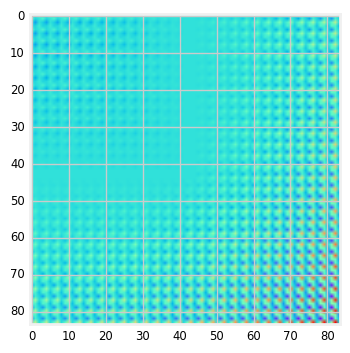

In [224]:
get_filter = get_filter_getter(model)
fs = get_filter(X_test[:20])
plt.imshow(filters_image(fs[0]))

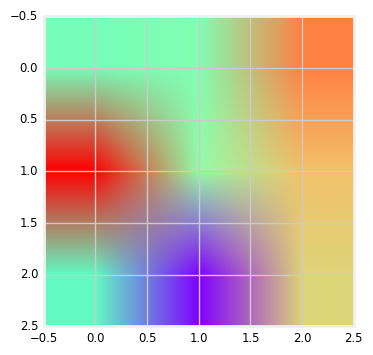

In [225]:
plt.imshow(fs[0, :, :, 0, 0])

In [226]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

class History(Callback):
    def on_train_begin(self, logs={}):
        self.filter = None

#     def on_batch_end(self, batch, logs={}):
#         self.filter = model.layers[1].filters.eval()
        
history = History()
        
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10,
          verbose=1, validation_data=(X_test, Y_test), callbacks=[history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 35s - loss: 0.3960 - acc: 0.8831 - val_loss: 0.2517 - val_acc: 0.9269
Epoch 2/10
60000/60000 [==============================] - 38s - loss: 0.2450 - acc: 0.9295 - val_loss: 0.2204 - val_acc: 0.9384
Epoch 3/10
60000/60000 [==============================] - 41s - loss: 0.2148 - acc: 0.9391 - val_loss: 0.1934 - val_acc: 0.9473
Epoch 4/10
60000/60000 [==============================] - 41s - loss: 0.1997 - acc: 0.9436 - val_loss: 0.2018 - val_acc: 0.9426
Epoch 5/10
60000/60000 [==============================] - 42s - loss: 0.1883 - acc: 0.9464 - val_loss: 0.1899 - val_acc: 0.9466
Epoch 6/10
60000/60000 [==============================] - 44s - loss: 0.1779 - acc: 0.9491 - val_loss: 0.1909 - val_acc: 0.9480
Epoch 7/10
60000/60000 [==============================] - 45s - loss: 0.1711 - acc: 0.9501 - val_loss: 0.1845 - val_acc: 0.9479
Epoch 8/10
60000/60000 [==============================

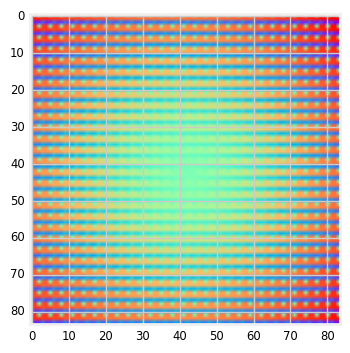

In [231]:
get_filter = get_filter_getter(model)
fs = get_filter(X_test[:20])
plt.imshow(filters_image(fs[0]))

In [ ]:
plt.imshow(fs[0][: , :, 0, 0])

In [229]:
gen = model.layers[1].gen

In [230]:
gen.coordinate_weights.eval()

b'CudaNdarray([ 0.08012717 -0.00618711  0.98710269])'